In [ ]:
from util.save_utils import save_all_models_per_epoch, save_best_performing_model, save_configuration_output

In [1]:
from constants import (
    BETA,
    NUMBER_INPUT_NEURONS,
    NUMBER_OUTPUT_NEURONS,
    THRESHOLD,
    TIME_STEPS,
)
from neural_nets.configurable_spiking_neural_net import ConfigurableSpikingNeuralNet
from training.train_snn import train_snn
from util.save_plots import save_history_plot, save_loss_per_time_step_plot

num_epochs = 'early_stopping'
sparsity = 0.2
number_hidden_neurons = 10
number_hidden_layer = 1
loss_configuration="population_coding"

model = ConfigurableSpikingNeuralNet(
    number_input_neurons=NUMBER_INPUT_NEURONS,
    number_hidden_neurons=number_hidden_neurons,
    number_output_neurons=NUMBER_OUTPUT_NEURONS,
    beta=BETA,
    threshold=THRESHOLD,
    time_steps=TIME_STEPS,
    number_hidden_layers=number_hidden_layer,
)

training_acc_history, test_acc_history, loss_history, total_training_time, epoch_loss_per_time_step, models_per_epoch, = train_snn(
    model,
    num_epochs=num_epochs,
    sparsity=sparsity,
    loss_configuration=loss_configuration,
    use_train_data_subset=1000
)

assert len(training_acc_history) == len(test_acc_history) == len(models_per_epoch)

save_best_performing_model(models_per_epoch, test_acc_history, './models/test.pth')

save_all_models_per_epoch(models_per_epoch, f'./models/test')

result_data = {
    "number_input_neurons": NUMBER_INPUT_NEURONS,
    "number_hidden_neurons": number_hidden_neurons,
    "number_output_neurons": NUMBER_OUTPUT_NEURONS,
    "beta": BETA,
    "threshold": THRESHOLD,
    "time_steps": TIME_STEPS,
    "number_hidden_layers": number_hidden_layer,
    "epochs": len(test_acc_history),
    "sparsity": sparsity,
    "loss_configuration": loss_configuration,
    "best_test_accuracy": np.max(test_acc_history),
    "training_accuracy": training_acc_history[np.argmax(test_acc_history)]
}

save_configuration_output(result_data, './output/test.json')

save_history_plot(training_acc_history, './output/test_train_acc.jpg')

save_history_plot(test_acc_history, './output/test_test_acc.jpg')

save_history_plot(loss_history, './output/test_loss.jpg')

if epoch_loss_per_time_step:
    save_loss_per_time_step_plot(epoch_loss_per_time_step, path=f'./output/test_loss_per_time_steps.png')

/home/mark/anaconda3/envs/whk-snn/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch: 0


AttributeError: 'list' object has no attribute 'shape'

In [ ]:
from util.plot_layer_development import plot_layer_development

plot_layer_development(models_per_epoch, [f'Epoch {epoch}' for epoch in range(len(models_per_epoch))])

# Plot layer development overfitted model

In [1]:
from neural_nets.configurable_spiking_neural_net import ConfigurableSpikingNeuralNet
from constants import NUMBER_INPUT_NEURONS, NUMBER_OUTPUT_NEURONS, BETA, THRESHOLD, TIME_STEPS

num_epochs = 500
sparsity = 0
number_hidden_neurons = 1000
number_hidden_layer = 1

base_net = ConfigurableSpikingNeuralNet(
    number_input_neurons=NUMBER_INPUT_NEURONS,
    number_hidden_neurons=number_hidden_neurons,
    number_output_neurons=NUMBER_OUTPUT_NEURONS,
    beta=BETA,
    threshold=THRESHOLD,
    time_steps=TIME_STEPS,
    number_hidden_layers=number_hidden_layer,
)

In [46]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from constants import TIME_STEPS
from tonic import datasets, transforms
from torch.utils.data import DataLoader
from util.get_device import get_device


def load_test_data():
    device = get_device()

    frame_transform = transforms.ToFrame(
        sensor_size=datasets.SHD.sensor_size, n_time_bins=TIME_STEPS
    )

    test_data = datasets.SHD("./data", transform=frame_transform, train=False)

    test_data_loader = DataLoader(test_data, shuffle=False, batch_size=32)

    data, _ = list(test_data_loader)[0]
    data = data.to_dense().to(torch.float32).squeeze().permute(1, 0, 2).to(device)
    return data


def get_spk_matrices(data, model, selection_index):
    x_selected = data[:, selection_index, :]

    spk_recs, _ = model(data)

    output_spk_rec = spk_recs[-1][:, selection_index, :]
    hidden_spk_rec = [
        hidden_spk_rec[:, selection_index, :].detach()
        for hidden_spk_rec in spk_recs[:-1]
    ]

    return [x_selected, *hidden_spk_rec, output_spk_rec.detach()]


def plot_layer_development(model, sub_titles, super_title=None):
    most_actives = []

    data = load_test_data()

    indices = [
        0, 1, 2, 3, 4
    ]

    spike_matrices = [
        get_spk_matrices(data, model, selection_index) for selection_index in indices
    ]

    print(len(spike_matrices))

    for spike_matrix in spike_matrices:
        assert len(spike_matrix) == len(spike_matrices[0])

    nrows = len(spike_matrices) if len(spike_matrices) > 1 else 2
    ncols = len(spike_matrices[0])

    figsize = (ncols * 5, nrows * 6)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

    if super_title:
        fig.suptitle(super_title, fontsize=16)

    for row_index, (spike_matrix, sub_title) in enumerate(
        zip(spike_matrices, sub_titles)
    ):
        for column_index in range(len(spike_matrices[0])):
            spike_matrix_np = spike_matrix[column_index].numpy()
            times, neurons = np.where(spike_matrix_np == 1)

            most_active = set([value for value, count in Counter(neurons).items() if count > 90])

            if column_index == 1:
                most_actives.append(most_active)

            ax = axes[row_index, column_index]

            ax.scatter(times, neurons, s=1, color="black")
            ax.set_title(f"{sub_title} - Layer {column_index}")
            ax.set_xlabel("Time step")
            ax.set_ylim(-1, spike_matrix_np.shape[1])
            if column_index == 0:
                ax.set_ylabel("Neuron index")

    plt.tight_layout()
    plt.show()

    return most_actives

In [27]:
data = load_test_data()
selection_index = 1
spike_matrix = get_spk_matrices(data, model, selection_index)

spike_matrix_np = spike_matrix[1].numpy()
times, neurons = np.where(spike_matrix_np == 1)

In [ ]:
from collections import Counter

most_active = [value for value, count in Counter(neurons).items() if count > 90]

set(most_active)

69

5


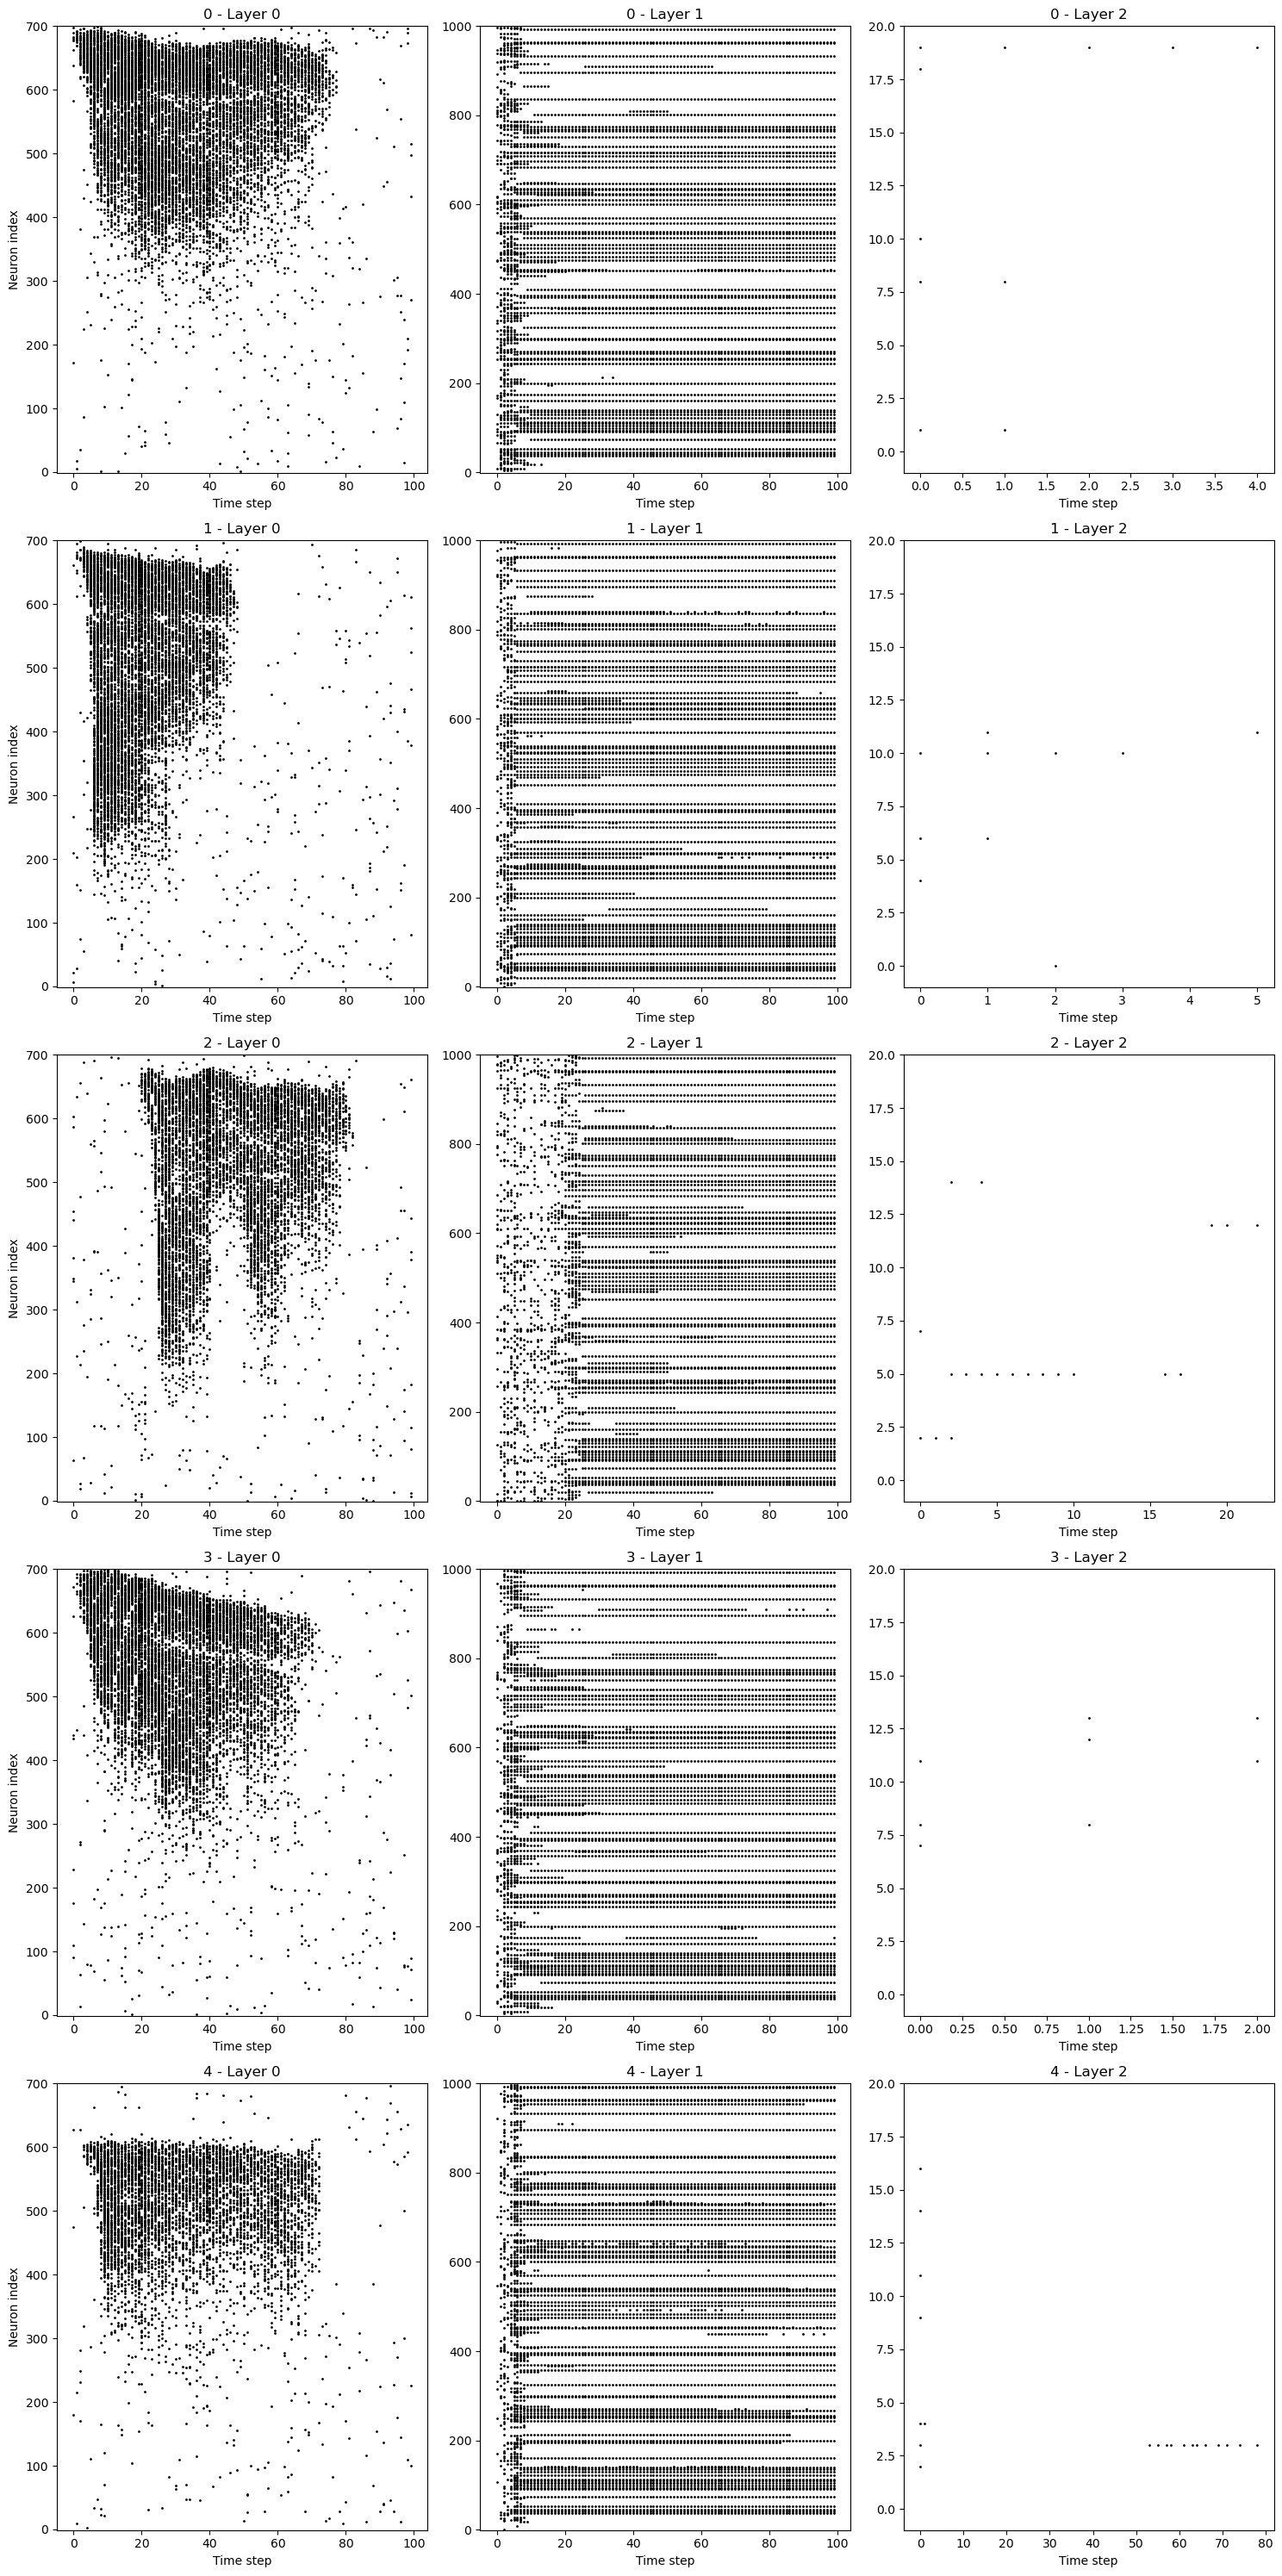

In [47]:
import copy
import torch

models = []

paths = [
    './models/experiment_point_of_chaos/500_epochs_epoch_499.pth',
]


for path in paths:
    model = copy.deepcopy(base_net)

    model_path = path

    model.load_state_dict(torch.load(model_path))
    models.append(model)

most_actives = plot_layer_development(model, sub_titles=[i for i in range(5)])

In [50]:
len(most_actives)

for e1 in most_actives:
    for e2 in most_actives:
        print(len(e1), len(e2), len(e1& e2))

64 64 64
64 69 61
64 0 0
64 60 60
64 66 58
69 64 61
69 69 69
69 0 0
69 60 59
69 66 61
0 64 0
0 69 0
0 0 0
0 60 0
0 66 0
60 64 60
60 69 59
60 0 0
60 60 60
60 66 56
66 64 58
66 69 61
66 0 0
66 60 56
66 66 66
